## Exercise 5 - Restricted Boltzman machines

Group: Ragù

Members: Matteo Bortoletto, Clelia Corridori, Filippo Costa, Edoardo Spadetto

In [1]:
import numpy as np
from numpy import exp
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import random

## Data storage

In [2]:
N = 10000 
C = 4 
Z = 2 
L = C*Z 
q = 0.1

y = [0]*N
x = [[0]*L for j in range(N)]
v0 = [0]*Z
v1 = [1]*Z
case = (v1 + v0 + v1 + v0,
        v0 + v1 + v1 + v0,
        v1 + v0 + v0 + v1,
        v0 + v1 + v0 + v1,
        v1 + v1 + v1 + v1)

for c in range(C):
    print('"', c , '"', *case[c], sep = "")

    
random.seed(12345)

for i in range(N):
    y[i] = random.randint(0,3)
    x[i][:] = case[y[i]]
    for j in range(L):
        if random.random()<0.1:
            x[i][j] = 1-x[i][j]
            
for i in range(10):
    print('"', y[i] , '"', *x[i], sep = "")
    
fname = 'dataRBM_q'+str(q)+'.csv'
print(fname)

with open (fname, mode='w') as myfile:
    writer = csv.writer(myfile, delimiter=',')
    for i in range(N):
        writer.writerow(x[i])

"0"11001100
"1"00111100
"2"11000011
"3"00110011
"3"00110011
"3"00110011
"1"00110100
"3"10110111
"1"00111100
"1"00111100
"2"11000010
"3"10110011
"3"01110011
"0"10001100
dataRBM_q0.1.csv


## Read data

In [3]:
fname = 'dataRBM_q0.1.csv'

data = np.loadtxt(fname, delimiter=',', dtype=int)
N = len(data)
L = len(data[1])
print(f'each of N={N} data has L={L} digits')

each of N=10000 data has L=8 digits


## Convert data to +1/-1 (spins)

In [4]:
v = 2*data - 1 
v0 = np.zeros_like(v)
v0[:] = v[:]
for k in range(10):
    print(data[k],v[k])

[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 1 0 0] [-1 -1  1  1 -1  1 -1 -1]
[1 0 1 1 0 1 1 1] [ 1 -1  1  1 -1  1  1  1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
[1 1 0 0 0 0 1 0] [ 1  1 -1 -1 -1 -1  1 -1]
[1 0 1 1 0 0 1 1] [ 1 -1  1  1 -1 -1  1  1]
[0 1 1 1 0 0 1 1] [-1  1  1  1 -1 -1  1  1]
[1 0 0 0 1 1 0 0] [ 1 -1 -1 -1  1  1 -1 -1]


In [5]:
np.random.seed(12342)
M = 2

sigma = np.sqrt(4. / float(L+M))

w = sigma * (2*np.random.rand(L,M) - 1) 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

print(w)
print(a)
print(b)
#store initial weights
w0, a0, b0 = w, a, b

[[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
[-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
[0. 0.]


## Functions for Plotting

[0, 0, 0, 0, 0, 0, 0, 0]
[1, 1]


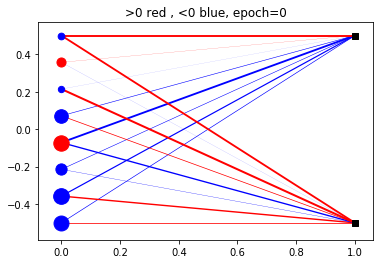

In [6]:

def create_coord(np,x0): 
    x=[x0]*np
    print(x)
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.)-0.5 
    return(x,y)

(x1,y1) = create_coord(L,0)
(x2,y2) = create_coord(M,1)

def mycolor(val):
    if val>0:
        return 'red'
    elif val<0:
        return 'blue'
    return 'black'

def plotgraph(epoch=0):
    A = 2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j]))
  
    PS=400.
    PSmin=40
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=max(PSmin,PS*np.abs(a[i])), zorder=2, c=mycolor(a[i]))
    for i in range(M):
        plt.scatter(x2[i], y2[i], s=max(PSmin,PS*np.abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    plt.title(f'>0 red , <0 blue, epoch={epoch}')
    plt.show()

plotgraph() 


## 1 & 2. Introduce a “temperature” in the sigmoid function

In [7]:

def activate(v_in, wei, bias, beta=1,info=False):
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + exp(-act*beta))
    n = np.shape(act)
    v_out = -np.ones(n, dtype=int)
    v_out[np.random.random_sample(n)<prob] = 1
    if info:
        print('input=', v_in)
        print('act=', act)
        print('prob=', prob)
        print('output=', v_out) 
    return v_out

k = 0
activate(v[k],w,b,info=True)

input= [-1 -1  1  1 -1 -1  1  1]
act= [-1.4184683   0.61989888]
prob= [0.19490182 0.65019555]
output= [-1  1]


array([-1,  1])

### RMB train

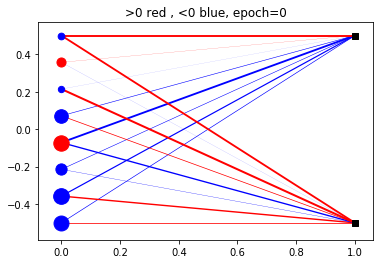

In [8]:
plotgraph(0)
#learning rate
l_rate = 1.0
#minibatch size
mini, m = 500,0
#epochs
max_epoch = 20

#train the model
def rbm_train(beta,w,b,a,max_epoch=20,l_rate=1.0,mini=500,M=2):
    m=0
    for epoch in range(1,1+max_epoch):
        l_rate_m = l_rate/mini
        for k in range(N):
            if m==0:
                
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
            
            h = activate(v[k],w,b,beta)
            
            vf = activate(h,w.T,a,beta)
            
            hf = activate(vf,w,b,beta)

            v_data += v[k]
            v_model += vf
            h_data += h 
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model += np.outer(vf.T,hf)

            m += 1
            # minibatch
            if m==mini:
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                if epoch<=2 and k<=mini:
                    print('--------- epoch =', epoch, ' k=', k, ' m=', m)
                    print('dw =', dw)
                    print('da =', da)
                    print('db =', db)
                w = w + dw
                a = a + da
                b = b + db
                m = 0

        print('completed epoch ', epoch, ' with l_rate= ', l_rate)

    
            
        np.random.shuffle(v)
        
        l_rate = l_rate /(0.2*l_rate+1)
            
    return([w,b,a])

In [9]:
print('w0 = ',w0)
print('w = ',w)
print('a0 = ',a0)
print('a = ',a)
print('b0 = ',b0)
print('b = ',b)

w0 =  [[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
w =  [[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
a0 =  [-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
a =  [-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
b0 =  [0. 0.]
b =  [0. 0.]


### Denoising

In [10]:
v1 = np.zeros_like(v0)

def score(l):
    w=l[0]
    b=l[1]
    a=l[2]
    for k in range(N):
        h = activate(v0[k],w,b)
        v1[k] = activate(h,w.T,a)

    diff = (v1 - v0)/2

    str0 = 'M'+str(M)+'-mini'+str(mini)+fname

    np.savetxt('fant-'+str0, (v1+1)/2, fmt='%d', delimiter=',')
    np.savetxt('diff-'+str0, diff    , fmt='%d', delimiter=',')

    Z = int(L/4)
    vv0 = [0]*Z
    vv1 = [1]*Z
    case = (vv1 + vv0 + vv1 + vv0,
            vv0 + vv1 + vv1 + vv0,
            vv1 + vv0 + vv0 + vv1, 
            vv0 + vv1 + vv0 + vv1,
            vv1 + vv1 + vv1 + vv1,
            vv1 + vv1 + vv0 + vv0)
    
    N_true=0
    for k in range(len(v0)):
        vec0 = ((v0[k]+1)/2).astype(int)
        vec1 = ((v1[k]+1)/2).astype(int)
        is0 = (vec1==case[0]).all()
        is1 = (vec1==case[1]).all()
        is2 = (vec1==case[2]).all()
        is3 = (vec1==case[3]).all()
        is4 = (vec1==case[4]).all()
        is5 = (vec1==case[5]).all()

        N_true +=int (is0 or is1 or is2 or is3 or is4 or is5)/len(v0)
        
    return N_true

In [11]:
b = [100,10,5,3,1,0.5,0.25,0.1,0.01]

N_true = [score(rbm_train(beta,w0,b0,a0)) for beta in b]

print(N_true)

--------- epoch = 1  k= 499  m= 500
dw = [[ 0.26  -0.412]
 [ 0.712 -0.168]
 [-1.188 -0.572]
 [ 0.264  0.776]
 [-0.38  -0.972]
 [-0.408 -1.072]
 [ 0.428  0.948]
 [-0.9   -0.212]]
da = [ 0.928  0.508  1.072 -0.452  1.032  0.076 -0.968  0.44 ]
db = [0.428 0.476]
completed epoch  1  with l_rate=  1.0
--------- epoch = 2  k= 499  m= 500
dw = [[-0.12666667  0.1       ]
 [-0.24666667  0.11333333]
 [ 0.25       -0.09666667]
 [-0.24333333  0.36333333]
 [ 0.03333333  0.18666667]
 [ 0.03333333  0.16      ]
 [ 0.39        0.22333333]
 [-0.06333333 -0.17      ]]
da = [-0.03333333  0.         -0.03       -0.47        0.04666667  0.05333333
 -0.44333333 -0.01      ]
db = [0. 0.]
completed epoch  2  with l_rate=  0.8333333333333334
completed epoch  3  with l_rate=  0.7142857142857143
completed epoch  4  with l_rate=  0.625
completed epoch  5  with l_rate=  0.5555555555555556
completed epoch  6  with l_rate=  0.5
completed epoch  7  with l_rate=  0.45454545454545453
completed epoch  8  with l_rate=  0.

completed epoch  18  with l_rate=  0.22727272727272735
completed epoch  19  with l_rate=  0.21739130434782616
completed epoch  20  with l_rate=  0.20833333333333343
--------- epoch = 1  k= 499  m= 500
dw = [[ 0.132 -0.012]
 [ 0.152  0.04 ]
 [-0.18  -0.004]
 [-0.072  0.088]
 [ 0.016 -0.112]
 [-0.084 -0.26 ]
 [-0.024  0.12 ]
 [-0.096 -0.032]]
da = [ 0.2    0.284  0.016 -0.22   0.132  0.024 -0.052  0.028]
db = [-0.012 -0.028]
completed epoch  1  with l_rate=  1.0
--------- epoch = 2  k= 499  m= 500
dw = [[ 0.07666667  0.01333333]
 [ 0.03666667 -0.03333333]
 [-0.04333333  0.04      ]
 [-0.00666667  0.03      ]
 [-0.01333333 -0.02333333]
 [ 0.03333333 -0.06333333]
 [ 0.03        0.06666667]
 [-0.00666667  0.05      ]]
da = [ 0.03666667  0.00333333 -0.01666667 -0.04       -0.02666667 -0.01333333
 -0.03       -0.02      ]
db = [ 0.01333333 -0.01666667]
completed epoch  2  with l_rate=  0.8333333333333334
completed epoch  3  with l_rate=  0.7142857142857143
completed epoch  4  with l_rate=  0.

In [12]:
for i in range(len(b)):
    print('T:{:3.1f}'.format(1/b[i]), '          accuracy : {:3.3f}%'.format(N_true[i]*100))

T:0.0           accuracy : 2.170%
T:0.1           accuracy : 2.560%
T:0.2           accuracy : 3.220%
T:0.3           accuracy : 5.090%
T:1.0           accuracy : 42.660%
T:2.0           accuracy : 91.320%
T:4.0           accuracy : 99.870%
T:10.0           accuracy : 100.000%
T:100.0           accuracy : 10.140%


Using $b=1$ we get an accuracy of 42.7%. Using the best $b$ found, which is $b=0.1$ ($T=10$), we get an accuracy of 100%.

## 3. Minimum number of hidden units introducing a 4th state 

In [13]:
C=4
N = 10000 
Z = 2 
L = C*Z 
q = 0.1

y = [0]*N
x = [[0]*L for j in range(N)]
v0 = [0]*Z
v1 = [1]*Z
case2 = (v1 + v0 + v1 + v0,
        v0 + v1 + v1 + v0,
        v1 + v0 + v0 + v1,
        v0 + v1 + v0 + v1,
        v1 + v1 + v1 + v1)

for c in range(5):
    print('"', c , '"', *case2[c], sep = "")
        
random.seed(12345)

for i in range(N):
    y[i] = random.randint(0,4)
    x[i][:] = case2[y[i]]
    for j in range(L):
        if random.random()<0.1:
            x[i][j] = 1-x[i][j]

    
fname = 'dataRBM_q_5'+str(q)+'.csv'
print(fname)

with open (fname, mode='w') as myfile:
    writer = csv.writer(myfile, delimiter=',')
    for i in range(N):
        writer.writerow(x[i])

data = np.loadtxt(fname, delimiter=',', dtype=int)
N = len(data)
L = len(data[1])

v = 2*data - 1
v0 = np.zeros_like(v)
v0[:] = v[:]

#for k in range(10):
#    print(data[k],v[k])
    
np.random.seed(12342)
M=2

sigma = np.sqrt(4. / float(L+M))

w = sigma * (2*np.random.rand(L,M) - 1) 
a = sigma * (2*np.random.rand(L) - 1) 
b = np.zeros(M)

#print(w)
#print(a)
#print(b)

w0, a0, b0 = w, a, b

b=0.1
v1 = np.zeros_like(v0)
N_true=score(rbm_train(b,w0,b0,a0,M=2))

print(N_true)

"0"11001100
"1"00111100
"2"11000011
"3"00110011
"4"11111111
dataRBM_q_50.1.csv
--------- epoch = 1  k= 499  m= 500
dw = [[ 0.108  0.044]
 [ 0.004 -0.1  ]
 [ 0.024 -0.032]
 [ 0.032 -0.04 ]
 [ 0.112  0.016]
 [-0.06  -0.076]
 [ 0.084 -0.012]
 [-0.016 -0.08 ]]
da = [0.252 0.268 0.136 0.112 0.12  0.18  0.212 0.064]
db = [-0.08  -0.024]
completed epoch  1  with l_rate=  1.0
--------- epoch = 2  k= 499  m= 500
dw = [[ 0.02666667 -0.05666667]
 [ 0.07       -0.03333333]
 [-0.02666667  0.15      ]
 [-0.07        0.02      ]
 [-0.02       -0.06333333]
 [ 0.         -0.01666667]
 [ 0.01        0.06      ]
 [ 0.01        0.        ]]
da = [ 0.19333333  0.13666667  0.          0.01       -0.04        0.03333333
  0.14333333  0.11      ]
db = [ 0.05333333 -0.05666667]
completed epoch  2  with l_rate=  0.8333333333333334
completed epoch  3  with l_rate=  0.7142857142857143
completed epoch  4  with l_rate=  0.625
completed epoch  5  with l_rate=  0.5555555555555556
completed epoch  6  with l_rate=  0.5

The  minimum number of hidden units (using a temperature $T=4$) is M=2 and the accuracy is $99.9$%.

## 4. Change error rate and  block lenght

In [14]:
C=4
N = 10000
Z = 3 
L = C*Z 
q = 0.3

y = [0]*N
x = [[0]*L for j in range(N)]
v0 = [0]*Z
v1 = [1]*Z
case2 = (v1 + v0 + v1 + v0,
        v0 + v1 + v1 + v0,
        v1 + v0 + v0 + v1,
        v0 + v1 + v0 + v1,
        v1 + v1 + v1 + v1,
        v1 + v1 +v0 + v0)

for c in range(6):
    print('"', c , '"', *case2[c], sep = "")
       
random.seed(12345)

for i in range(N):
    y[i] = random.randint(0,4)
    x[i][:] = case2[y[i]]
    for j in range(L):
        if random.random()<q:
            x[i][j] = 1-x[i][j]

fname = 'dataRBM_q_6'+str(q)+'.csv'
print(fname)

with open (fname, mode='w') as myfile:
    writer = csv.writer(myfile, delimiter=',')
    for i in range(N):
        writer.writerow(x[i])

data = np.loadtxt(fname, delimiter=',', dtype=int)
N = len(data)
L = len(data[1])

v = 2*data - 1 
v0 = np.zeros_like(v)
v0[:] = v[:]

#for k in range(10):
#    print(data[k],v[k])
    
np.random.seed(12342)
M=3

sigma = np.sqrt(4. / float(L+M))

w = sigma * (2*np.random.rand(L,M) - 1) 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

#print(w)
#print(a)
#print(b)

w0, a0, b0 = w, a, b

b=0.1
v1 = np.zeros_like(v0)
N_true=score(rbm_train(b,w0,b0,a0,M=3))

print('accuracy :',N_true*100,'%')

"0"111000111000
"1"000111111000
"2"111000000111
"3"000111000111
"4"111111111111
"5"111111000000
dataRBM_q_60.3.csv
--------- epoch = 1  k= 499  m= 500
dw = [[ 0.036  0.028  0.028]
 [-0.136 -0.008 -0.024]
 [-0.012  0.076 -0.124]
 [-0.08  -0.016  0.016]
 [ 0.02  -0.028 -0.124]
 [ 0.08  -0.04  -0.048]
 [ 0.052 -0.068 -0.004]
 [-0.028  0.028 -0.084]
 [-0.02   0.116 -0.108]
 [ 0.036  0.004  0.132]
 [ 0.04  -0.088 -0.008]
 [ 0.012 -0.116 -0.028]]
da = [ 0.032  0.036  0.08   0.148  0.184  0.068  0.048  0.08   0.192 -0.088
  0.052  0.016]
db = [ 0.044 -0.132 -0.044]
completed epoch  1  with l_rate=  1.0
--------- epoch = 2  k= 499  m= 500
dw = [[-0.01666667 -0.06666667 -0.01333333]
 [-0.00666667 -0.07        0.13666667]
 [-0.03333333 -0.04333333 -0.03      ]
 [ 0.02       -0.01       -0.01666667]
 [ 0.05666667  0.02        0.02      ]
 [-0.02        0.07        0.06333333]
 [-0.01666667 -0.02       -0.01333333]
 [-0.04        0.07        0.01666667]
 [-0.01        0.04666667 -0.06      ]
 [ 0.